In [1]:
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 121.8 MB/s eta 0:00:00


In [1]:
import time
import os
import shutil
from itertools import islice
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import findspark
findspark.init()

from google.cloud import storage

spark = SparkSession.builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "16g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "4") \
    .config("spark.dynamicAllocation.maxExecutors", "100") \
    .getOrCreate()



spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

print(spark.version)

3.1.3


# Read from folder into spark df

You will see 5 sub-folders, each containing a collection of parquet files.  A single folder can be read into Spark Dataframe:

* Commits (gs://msca-bdp-data-open/final_project_git/commits): This contains information about the commits made to repositories. Each commit has metadata such as the author, committer, commit date, SHA, parent commit(s), and commit message.

* Contents (gs://msca-bdp-data-open/final_project_git/contents): Provides the content of the files in the repositories. This is useful if you're looking to analyze source code or documents within repositories.

* Files (gs://msca-bdp-data-open/final_project_git/files): This contains metadata about the files in the repositories such as the file path, the mode, and the blob ID which links back to the content.

* Languages (gs://msca-bdp-data-open/final_project_git/languages): Each repository often has code written in one or more languages. This table provides an aggregation of the number of bytes of code for each language in a repository.

* Licenses (gs://msca-bdp-data-open/final_project_git/licenses): Contains information on the licenses used by repositories.
 

In [ ]:
#!hadoop fs -ls "gs://msca-bdp-data-open/final_project_git/commits"

In [2]:
# Read into spark df

commits_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/commits")
contents_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/contents")
files_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/files")
languages_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/languages")
licenses_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/licenses")

In [3]:
# Checking preliminary data schema
tables = [commits_spDf,contents_spDf,files_spDf,languages_spDf,licenses_spDf]

for i in tables:
    print(f"Table \n {i}")
    i.printSchema()

Table 
 +--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------+
|              commit|                tree|              parent|              author|           committer|             subject|             message|             trailer|difference|difference_truncated|           repo_name|encoding|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------+
|aa358905a1b12c6fa...|df3f8bf61bf1cb0df...|[ea230a45a0e97e4d...|{conda-forge-coor...|{conda-forge-coor...|Updated the qceng...|Updated the qceng...|                  []|        []|                true|[conda-forge/feed...|    null|
|5a6b6d6d29489f858...|ff89accb7e283ca88...|[4ee369feb64ee97d...|

Table 
 +--------------------+-------+--------------------+------+------+
|                  id|   size|             content|binary|copies|
+--------------------+-------+--------------------+------+------+
|d5b1049fdaa182fa5...|   1570|{"version":3,"sou...| false|   256|
|896830f9ea31efd6b...|  18616|                null|  true|     1|
|bf1e2a8490344601c...|  15580|                null|  true|     1|
|e5976431eba91aa73...|   3328|                null|  true|     1|
|311532e41682cab22...|   8970|                null|  true|     1|
|0f9f37090068023bc...|1060956|                null|  true|     1|
|9c78cf443f6f6c6fc...|  11208|                null|  true|     1|
|54f06fa18833e05a2...|    861|                null|  true|     1|
|fbf679e412e05e886...|    875|                null|  true|     1|
|74bc061ff301a4296...| 107097|                null|  true|     1|
|d665767b64cd53744...|  19641|                null|  true|     1|
|250d48293d0d0f437...|  60649|                null|  true|     1|
|3

Table 
 +--------------------+-----------------+--------------------+-----+--------------------+--------------+
|           repo_name|              ref|                path| mode|                  id|symlink_target|
+--------------------+-----------------+--------------------+-----+--------------------+--------------+
|    enzbang/diouzhtu|refs/heads/master|gwiad_wiki_servic...|33261|49365044eed287691...|          null|
|TheMrNomis/Latex-...|refs/heads/master|             LFM.php|33261|ef8cb78feed7f2111...|          null|
|TheMrNomis/Latex-...|refs/heads/master|PHP/LatexFlavored...|33261|d989ce59652f57efa...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJPu...|33261|85268b90caa19efa2...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/uexJPus...|33261|e1623bb9d8dc7db60...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJPu...|33261|28a191eb0791ad2b0...|          null|
|    xurigan/uexJPush|refs/heads/master|EUExJPush/EUExJP

Table 
 +--------------------+------------+
|           repo_name|    language|
+--------------------+------------+
|   lemi136/puntovent|   [{C, 80}]|
|      taxigps/nctool| [{C, 4461}]|
|         ahy1/strbuf| [{C, 5573}]|
| nleiten/mod_rpaf-ng|[{C, 30330}]|
| kmcallister/alameda|[{C, 17077}]|
|       TianYJ1/Snake|[{C, 10381}]|
|      doctorfree/Lds|[{C, 56413}]|
|SumiMakito/ReinaJ...| [{C, 7444}]|
|    serprex/rainbeam| [{C, 1964}]|
|   pdigiglio/oracolo| [{C, 1966}]|
|         jrb/vtclock|[{C, 23053}]|
|AhmedZanam/logica...| [{C, 1466}]|
|        ilardm/tsync|[{C, 64229}]|
|         lxzhu/runos|[{C, 21102}]|
|phillipgreenii/ir...| [{C, 3034}]|
|themaddoctor1/Mul...| [{C, 7774}]|
|Mr-Kumar-Abhishek...|  [{C, 233}]|
|tidatida/Small-Op...| [{C, 1664}]|
|magnusviri/matrix...|[{C, 93643}]|
|Atalanta/run-leng...|  [{C, 756}]|
+--------------------+------------+
only showing top 20 rows

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element

# EDA
What is the timeline of the data?  Do you see significant peaks and valleys?

Do you see any data collection gaps?

Do you see any outliers?  Remove obvious outliers before plotting the timeline

Do you see any spikes?  Are these spikes caused by real activities / events?

In [4]:
from pyspark.sql.functions import explode, col

# Step 1: Explode repo_name in commits_spDf
commits_exploded = commits_spDf.withColumn("repo_name_exploded", explode(col("repo_name")))

In [5]:
from pyspark.sql.functions import col, from_unixtime

timezone = commits_exploded.select(col("author.tz_offset"),col('repo_name_exploded'))
timezone_frequency = (
    timezone.groupBy("tz_offset", "repo_name_exploded")
    .count()
    .orderBy(col("count").desc())
)

# Show the results
#timezone_frequency.show(5)

In [6]:
rows = timezone_frequency.count()
print(f"total rows {rows}") # too big to turn into Pandas

total rows 10081301


In [7]:
top_repos = timezone.groupBy("repo_name_exploded").count().orderBy(col("count").desc()).limit(100)
top_repo_names = [row["repo_name_exploded"] for row in top_repos.collect()]

filtered_timezone = timezone.filter(col("repo_name_exploded").isin(top_repo_names))
timezone_frequency = (
    filtered_timezone.groupBy("tz_offset", "repo_name_exploded")
    .count()
    .orderBy(col("count").desc())
)

In [8]:
timezone_frequency = (
    timezone.groupBy("tz_offset")
    .agg({"repo_name_exploded": "count"})  # Count total commits per time zone
    .orderBy(col("count(repo_name_exploded)").desc())
)

In [9]:
row = timezone_frequency.count()
print(f"Total rows {row}")

Total rows 194


In [10]:
tz_pd = timezone_frequency.toPandas()

In [12]:
tz_pd.head(5)

,tz_offset,count(repo_name_exploded)
0,-420,638342149
1,0,543412058
2,120,524603507
3,60,493071709
4,-480,334732346


In [19]:
tz_pd['tz_offset_hour'] = tz_pd['tz_offset']/60
display(tz_pd)

,tz_offset,count(repo_name_exploded),tz_offset_hour
0,-420,638342149,-7.000000
1,0,543412058,0.000000
2,120,524603507,2.000000
3,60,493071709,1.000000
4,-480,334732346,-8.000000
...,...,...,...
189,-5292855,1,-88214.250000
190,-947370,1,-15789.500000
191,-5293318,1,-88221.966667
192,-148,1,-2.466667


In [20]:
filtered_tz_pd = tz_pd[(tz_pd["tz_offset_hour"] >= -12) & (tz_pd["tz_offset_hour"] <= 12)]

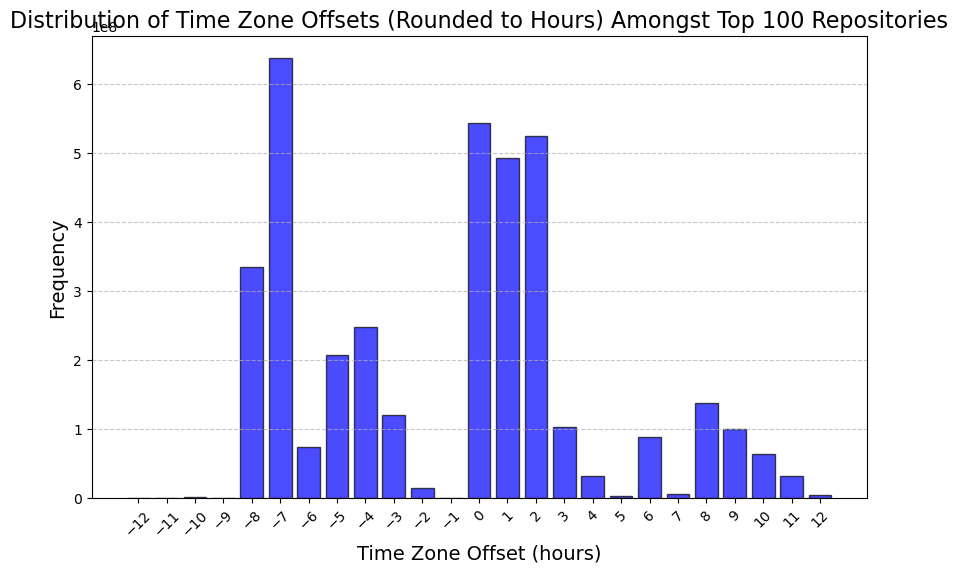

In [28]:
import numpy as np

# Add a new column for rounded time zone offset
tz_pd["tz_offset_rounded"] = np.round(tz_pd["tz_offset_hour"])

# Group by the rounded time zone offset and sum the counts
filtered_tz_pd = (
    tz_pd[(tz_pd["tz_offset_hour"] >= -12) & (tz_pd["tz_offset_hour"] <= 12)]
    .groupby("tz_offset_rounded", as_index=False)["count(repo_name_exploded)"]
    .sum()
)

# Rename columns for clarity (optional)
filtered_tz_pd.rename(columns={"tz_offset_rounded": "tz_offset", "count(repo_name_exploded)": "count"}, inplace=True)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(filtered_tz_pd["tz_offset"], filtered_tz_pd["count"], color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Time Zone Offsets (Rounded to Hours) Amongst Top 100 Repositories', fontsize=16)
plt.xlabel('Time Zone Offset (hours)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(-12, 13), rotation=45)  # Rotate the x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


KeyError: 'count'

<Figure size 1000x600 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Group by tz_offset and count the frequencies
timezone_frequency = timezone.groupBy("tz_offset").count().orderBy(col("tz_offset"))

# Convert the result to a Pandas DataFrame for plotting
timezone_pd = timezone_frequency.toPandas()

# Plot the distribution of tz_offset
plt.figure(figsize=(10, 6))
plt.bar(timezone_pd["tz_offset"], timezone_pd["count"], color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Time Zone Offsets (tz_offset)', fontsize=16)
plt.xlabel('Time Zone Offset (hours)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(timezone_pd["tz_offset"])  # Display each time zone offset on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [6]:


# Extract commit timestamp
commits_spDf = commits_spDf.withColumn("author_timestamp", from_unixtime(col("author.date.seconds")))
commits_spDf = commits_spDf.withColumn("committer_timestamp", from_unixtime(col("committer.date.seconds")))
commits_spDf = commits_spDf.withColumn("author_commit_date", col("author_timestamp").cast("date"))
commits_spDf = commits_spDf.withColumn("committer_commit_date", col("committer_timestamp").cast("date"))

# View sample data
%time commits_spDf.select("committer_timestamp", "author_timestamp").show(5)

+-------------------+-------------------+
|committer_timestamp|   author_timestamp|
+-------------------+-------------------+
|2022-03-15 15:11:13|2022-03-15 15:11:13|
|2011-12-09 15:05:17|2011-12-09 15:05:17|
|2011-04-27 17:17:23|2011-04-27 17:17:23|
|2022-01-26 12:39:56|2022-01-26 12:39:56|
|2014-03-06 04:30:00|2014-03-06 04:30:00|
+-------------------+-------------------+
only showing top 5 rows

CPU times: user 2.07 ms, sys: 324 µs, total: 2.39 ms
Wall time: 670 ms


In [7]:
%time commits_spDf.select("committer_commit_date", "author_commit_date").show(5)

+---------------------+------------------+
|committer_commit_date|author_commit_date|
+---------------------+------------------+
|           2022-03-15|        2022-03-15|
|           2011-12-09|        2011-12-09|
|           2011-04-27|        2011-04-27|
|           2022-01-26|        2022-01-26|
|           2014-03-06|        2014-03-06|
+---------------------+------------------+
only showing top 5 rows

CPU times: user 4.91 ms, sys: 769 µs, total: 5.68 ms
Wall time: 1 s


In [8]:
from pyspark.sql.functions import count

# Aggregate by date
author_timeline_df = commits_spDf.groupBy("author_commit_date").agg(count("*").alias("author_commit_count"))
committer_timeline_df = commits_spDf.groupBy("committer_commit_date").agg(count("*").alias("committer_commit_count"))

# Sort by date for visualization
author_timeline_df = author_timeline_df.orderBy("author_commit_date")
author_timeline_df.show(10)

committer_timeline_df = committer_timeline_df.orderBy("committer_commit_date")
%time committer_timeline_df.show(10)

+------------------+-------------------+
|author_commit_date|author_commit_count|
+------------------+-------------------+
|              null|              26300|
|        1970-01-01|                234|
|        1970-01-02|                 31|
|        1970-01-03|                  8|
|        1970-01-04|                 13|
|        1970-01-05|                 12|
|        1970-01-06|                 13|
|        1970-01-07|                  4|
|        1970-01-08|                  2|
|        1970-01-09|                  1|
+------------------+-------------------+
only showing top 10 rows



+---------------------+----------------------+
|committer_commit_date|committer_commit_count|
+---------------------+----------------------+
|                 null|                 26365|
|           1970-01-01|                   214|
|           1970-01-02|                    21|
|           1970-01-03|                     7|
|           1970-01-04|                     6|
|           1970-01-05|                    10|
|           1970-01-06|                     2|
|           1970-01-07|                     4|
|           1970-01-08|                     1|
|           1970-01-09|                     1|
+---------------------+----------------------+
only showing top 10 rows

CPU times: user 278 ms, sys: 42.6 ms, total: 320 ms
Wall time: 1min 27s


In [ ]:
author_timeline_pdDf = author_timeline_df.toPandas()

In [ ]:
display(author_timeline_pdDf.head(5))
display(author_timeline_pdDf.tail(50))

In [ ]:
committer_timeline_pdDf = committer_timeline_df.toPandas()

In [ ]:
display(committer_timeline_pdDf.head(5))
display(committer_timeline_pdDf.tail(50))

In [ ]:
pdDf = [author_timeline_pdDf, committer_timeline_pdDf]
titles = ['author','committer']

In [ ]:
for df, val in zip(pdDf, titles):
    df['Date'] = pd.to_datetime(df[f'{val}_commit_date'])
    #df = df.dropna(inplace=True)
    print(f"For table {val}")
    print(f"Earliest commit date in record is {df['Date'].min()}")
    print(f"Latest commit date in record is {df['Date'].max()}")

In [ ]:
for df, title in zip(pdDf, titles):
    x_col = f'{title}_commit_date'
    y_col = f'{title}_commit_count'
    
    df[x_col] = pd.to_datetime(df[x_col])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_col], df[y_col], marker='o', label=f'{title} timeline')
    
    # Adding labels and title
    plt.xlabel('Commit Date')
    plt.ylabel('Commit Count')
    plt.title(f'{title.capitalize()} Commit Timeline')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

In [ ]:
committer_timeline_pdDf.tail(5560)

# Remove outliar that is likely to be errors

Now notice that there are a lot of future dates after 2022-11-27 that have only 2 counts. We don't want to see because they are likely errors. So we decide to filter out dates on and after 2022-11-27.

In [ ]:
# Filter rows where the dates are before 2022-11-27
from pyspark.sql.functions import year,col

cutoff_date = "2022-11-27"
commits_spDf = commits_spDf.filter((col("author_timestamp") < cutoff_date) & (col("committer_timestamp") < cutoff_date))

# View the filtered data
%time commits_spDf.select("committer_timestamp", "author_timestamp").show(5)

In [ ]:
# Aggregate by date
author_timeline_df = commits_spDf.groupBy("author_commit_date").agg(count("*").alias("author_commit_count"))
committer_timeline_df = commits_spDf.groupBy("committer_commit_date").agg(count("*").alias("committer_commit_count"))

# Sort by date for visualization
author_timeline_df = author_timeline_df.orderBy("author_commit_date")
author_timeline_df.show(10)

committer_timeline_df = committer_timeline_df.orderBy("committer_commit_date")
committer_timeline_df.show(10)

In [ ]:
author_timeline_pdDf_filtered = author_timeline_df.toPandas()

In [ ]:
committer_timeline_pdDf_filtered = committer_timeline_df.toPandas()

In [ ]:
committer_timeline_pdDf_filtered.tail(30)

In [ ]:
pdDf = [author_timeline_pdDf_filtered, committer_timeline_pdDf_filtered]
titles = ['author','committer']

for df, title in zip(pdDf, titles):
    x_col = f'{title}_commit_date'
    y_col = f'{title}_commit_count'
    
    df[x_col] = pd.to_datetime(df[x_col])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_col], df[y_col], marker='o',s=10, label=f'{title} timeline')
    
    # Adding labels and title
    plt.xlabel('Commit Date')
    plt.ylabel('Commit Count')
    plt.title(f'{title.capitalize()} Commit Timeline')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Popular Language Over Time

In [9]:
from pyspark.sql.functions import explode, col

# Step 1: Explode repo_name in commits_spDf
commits_exploded = commits_spDf.withColumn("repo_name_exploded", explode(col("repo_name")))

# Step 2: Join languages_spDf and exploded commits_spDf on repo_name
merged_df = languages_spDf.alias("lang").join(
    commits_exploded.alias("commit"),
    col("lang.repo_name") == col("commit.repo_name_exploded"),
    "inner"
)

# Step 3: Select relevant columns including time columns
result_df = merged_df.select(
    col("lang.repo_name").alias("repo_name"),           # from languages_spDf
    col("lang.language").alias("language"),            # from languages_spDf
    col("lang.language.bytes").alias("language_bytes"), # language bytes
    col("commit.author_commit_date").alias("author_commit_date"), # from commits_spDf
    col("commit.committer_commit_date").alias("committer_commit_date"), # from commits_spDf
)



In [11]:
%time language_time = result_df.groupBy(["committer_commit_date","language"]).agg(count("*").alias("Count"))

CPU times: user 1.64 ms, sys: 4.62 ms, total: 6.26 ms
Wall time: 30.7 ms


In [12]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/final_language_count.parquet"

# Write the DataFrame to GCS as a Parquet file
language_time.write \
    .mode("overwrite") \
    .parquet(bucket_write)

print(f"DataFrame successfully written to {bucket_write}")


DataFrame successfully written to gs://msca-bdp-students-bucket/shared_data/xiuan/final_language_count.parquet


## Re-read from save

In [ ]:
bucket_read_path = "gs://msca-bdp-students-bucket/shared_data/xiuan/final_language_count.parquet"

# Read the Parquet file into a Spark DataFrame
sampled_df = spark.read.parquet(bucket_read_path)

%time sampled_df.limit(5)

In [4]:
# Step 4: Convert to Pandas for aggregation and plotting
%time result_df = sampled_df.sample(fraction=0.01, seed=99)

CPU times: user 1.66 ms, sys: 466 µs, total: 2.12 ms
Wall time: 45.1 ms


In [ ]:
%time sampled_pd = result_df.toPandas()

In [ ]:
bucket_write = "gs://msca-bdp-students-bucket/shared_data/xiuan/final_language_count.csv"
sampled_pd.to_csv(bucket_write)

In [ ]:
result_pd.head(5)

In [ ]:
import matplotlib.pyplot as plt

# Convert `committer_commit_date` to datetime format
sampled_pd["committer_commit_date"] = pd.to_datetime(sampled_pd["committer_commit_date"])

# Group by date and language to count occurrences
language_trend = sampled_pd.groupby(
    [sampled_pd["committer_commit_date"].dt.to_period("M"), "language"]
).sum().reset_index()

# Rename columns for clarity
language_trend.rename(columns={"committer_commit_date": "Month", "Count": "Total_Count"}, inplace=True)

# Pivot the data to prepare for visualization
pivot_data = language_trend.pivot(index="Month", columns="language", values="Total_Count").fillna(0)

# Plotting a line chart for each language
pivot_data.index = pivot_data.index.to_timestamp()  # Convert period to timestamp
plt.figure(figsize=(15, 8))

for language in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[language], label=language)

plt.title("Trend of Popular Programming Languages Over Time", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Number of Commits", fontsize=12)
plt.legend(title="Language", loc="upper left")
plt.grid(True)
plt.show()

# License distribution
What is the distribution of licenses across GitHub repositories?
Any certain programming languages that are more likely to be associated with a particular license?

In [ ]:
license_count = license_spDf.withColumn("Count",count('License'))
license_count.to_Panda()